# Explore Customer Data
  Should be applicable to all customer data sets,
  Explores categories as well as time series


In [1]:
"""
from sklearn.datasets import fetch_openml
from sklearn import datasets, svm, metrics
from pandas import DataFrame
import matplotlib as mpl
"""

from typing import List, Tuple

# from dataclasses import dataclass
import pandas as pd

# import numpy as np

import matplotlib.pyplot as plt
import matplotlib

# import glob
import os
from pathlib import Path

# get nltk and corpus
# import nltk
# from nltk.corpus import stopwords

# get scapy and corpus
# import spacy
# import time
# from functools import lru_cache
import seaborn as sns
import humanize

# import swifter
import dask
import dask.dataframe as dd
from IPython.display import display

from humanize import intcomma, intword
import pandas_profiling
import arrow
import datetime
from functools import partial
from pandas_util import time_it

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


/home/idvorkin/.local/share/virtualenvs/jupyter-mS77vUq-/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


pandas util 0.02


In [4]:
# make the plot wider
height_in_inches = 10
matplotlib.rc("figure", figsize=(2 * height_in_inches, height_in_inches))

# Load Data set

In [5]:
# raw_csv = "~/data/wamd.all.csv"
raw_csv = "~/data/all.messages.csv"
cleaned_df_pickled = f"{os.path.expanduser(raw_csv)}.pickle.gz"


# Load+Clean+Explore data using Dask as it's got multi-core.
# Then convert to a pandas dataframe pickle.
# df = dd.read_csv(raw_csv,sep='\t' )
# df = df.compute()
# df = pd.read_csv(raw_csv,sep='\t')
# df = pd.read_csv(raw_csv, sep="|", lineterminator="\n", error_bad_lines=False)
# df = pd.read_csv(raw_csv, sep="\t", lineterminator='\r"')
df

NameError: name 'df' is not defined

In [6]:
# clean up some  data

datetimeColumnName, customerIdColumnName = "date_uct", "id"

# setup date column
df["datetime"] = pd.to_datetime(df[datetimeColumnName], errors="coerce")
df = df.set_index(df.datetime)
# setup customer id
df["customer_id"] = df[customerIdColumnName]

NameError: name 'df' is not defined

In [7]:
# df = df.compute()
# df.to_pickle(cleaned_df_pickled)
ti = time_it(f"Load dataframe:{cleaned_df_pickled}")
df = pd.read_pickle(cleaned_df_pickled)
ti.stop()

++ Load dataframe:/home/idvorkin/data/all.messages.csv.pickle.gz
-- [0s]: Load dataframe:/home/idvorkin/data/all.messages.csv.pickle.gz


In [8]:
# df = df.compute()
# df.to_pickle(cleaned_df_pickled)

In [9]:
# df = df.compute()
# df.to_pickle(cleaned_df_pickled)
# df.set_index
# df = df.reset_index(drop=True)
# kdf.index

# Data Analysis -
### Home Grown

In [10]:
# gotta be a more elegant way, but doing this for now

ti = time_it("compute distribution")
distribs = [df[c].value_counts(normalize=True).toPercent() for c in df.columns]
ti.stop()

++ compute distribution
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
-- [0s]: compute distribution


In [11]:
def isFlatDistribution(d):
    return len(d) == 0 or d.iloc[0] < 0.01


for d in sorted(
    [d for d in distribs if not isFlatDistribution(d)], key=lambda d: d.iloc[0] * -1
):
    column_header = f"\n------ {d.name} ----- "
    print(column_header)
    print(f"{d.head(10)}")

print("++Flat distribution++")
for d in sorted([d for d in distribs if isFlatDistribution(d)], key=lambda d: d.name):
    c = d.name
    print(c)
print("--Flat distribution--")


------ destination_caller_id ----- 
+12068904339          99.723570
idvorkin@gmail.com     0.264144
+12068909755           0.006143
tel:+12068904339       0.003071
1                      0.003071
Name: destination_caller_id, dtype: float64

------ id ----- 
+19172255233    55.775380
+12063567091    12.619904
+19165381869     8.713030
+12068909755     6.264988
+12067246273     1.603717
+14253014747     1.563749
+12064837361     1.224021
+19059237385     1.199041
+13134388147     0.799361
+14254421739     0.679456
Name: id, dtype: float64

------ customer_id ----- 
+19172255233    55.775380
+12063567091    12.619904
+19165381869     8.713030
+12068909755     6.264988
+12067246273     1.603717
+14253014747     1.563749
+12064837361     1.224021
+19059237385     1.199041
+13134388147     0.799361
+14254421739     0.679456
Name: customer_id, dtype: float64

------ is_from_me ----- 
0                      52.185069
1                      47.812172
2019-03-09 20:11:50     0.002759
Name: is_f

# Data Analysis -
### Like the grown ups do.

In [18]:
# This looks pretty crappy on a black background, maybe change color first
# Also, I've had trouble with date indexes, might need to drop the index
# df = df.reset_index(drop = True)
profile_filename = "output.html"
ti = time_it(f"profiling dataframe to {profile_filename}")
# pr = df.reset_index(drop=True).profile_report()
# pr.to_file(output_file=profile_filename)
# pr
ti.stop()

++ profiling dataframe to output.html
-- [0s]: profiling dataframe to output.html


# Customer Distribution Analysis

++ Plotting distributions
<class 'pandas.core.series.Series'>


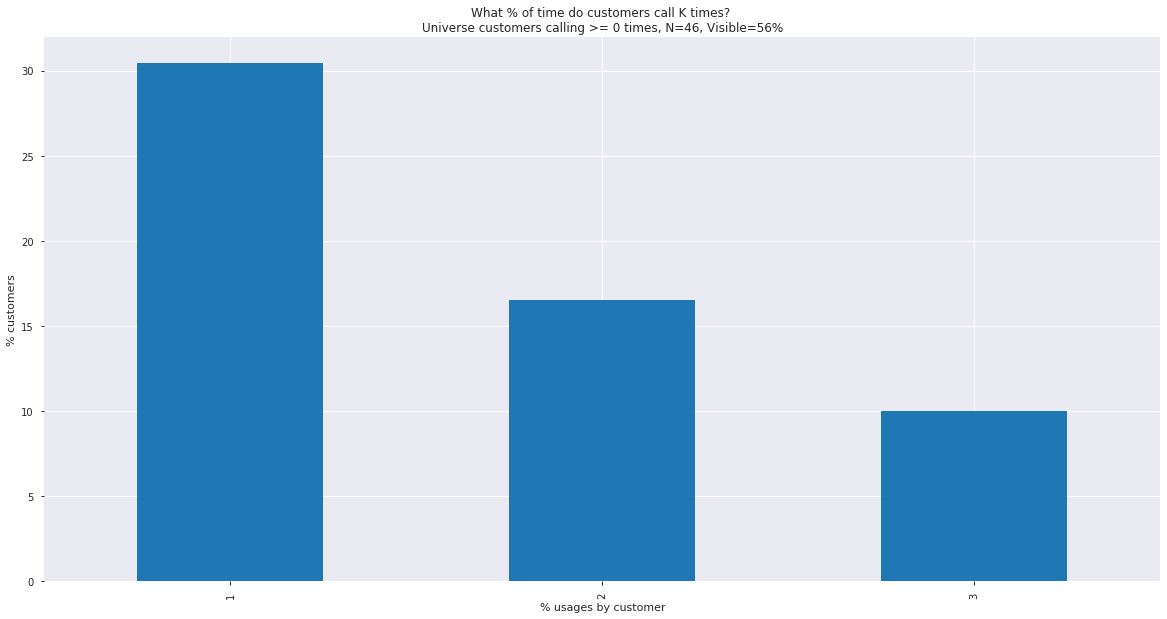

<class 'pandas.core.series.Series'>


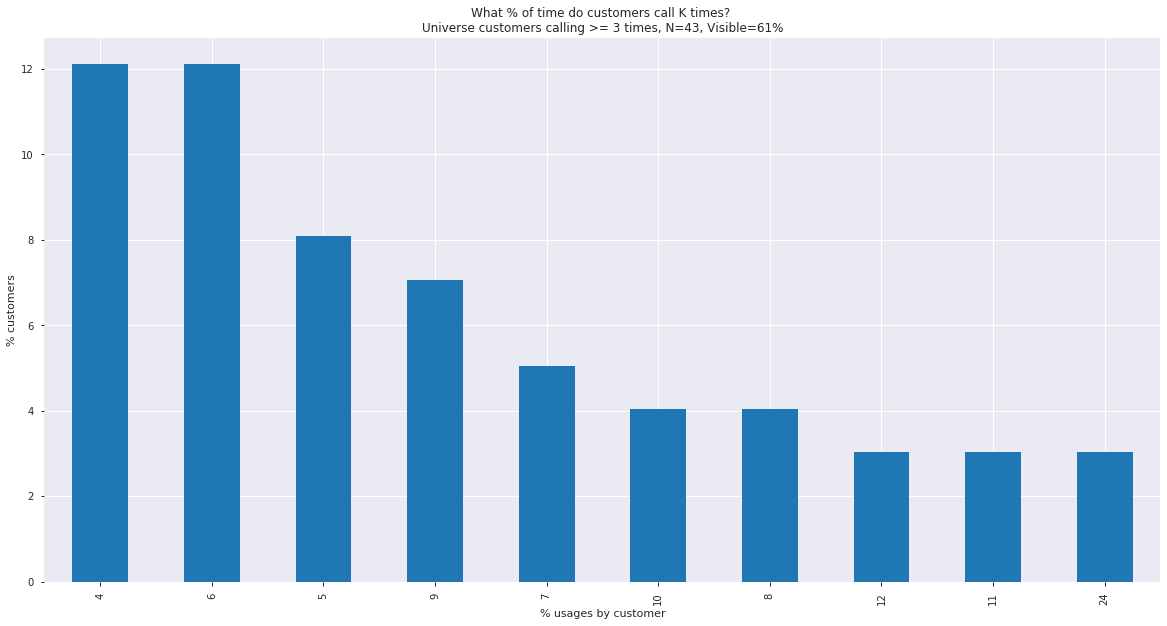

<class 'pandas.core.series.Series'>


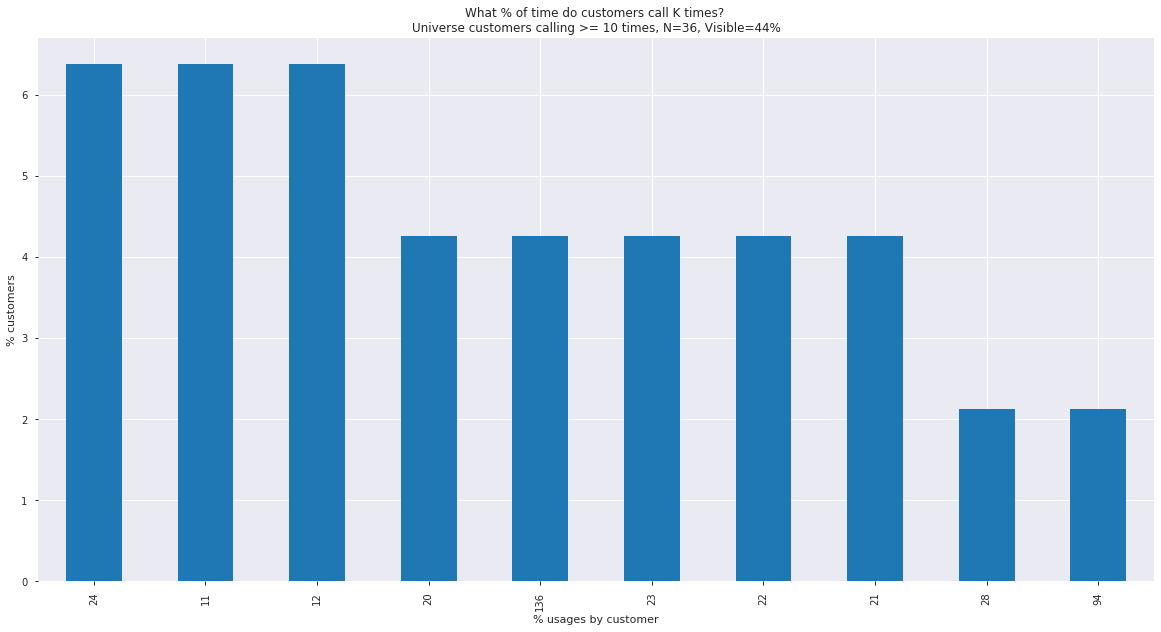

<class 'pandas.core.series.Series'>


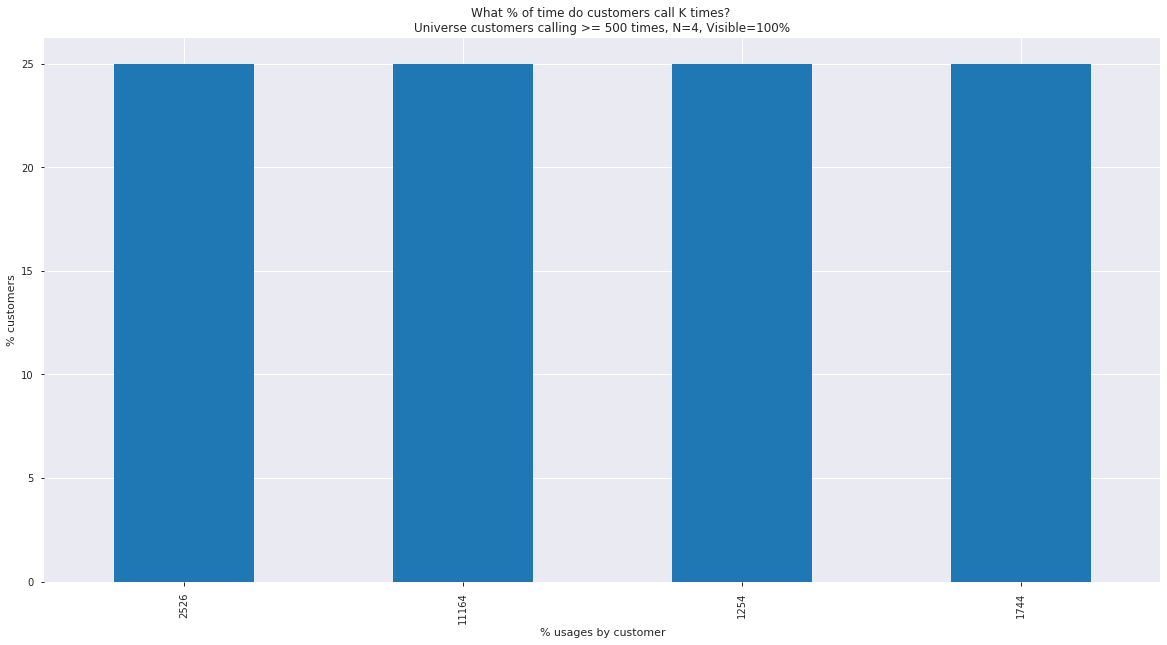

-- [1s]: Plotting distributions


In [19]:
def plot_distribution_for(df, count_buckets, minimum_call_count=0):
    cid = "customer_id"
    usage_by_cid = df[cid].value_counts()
    cid_to_exclude = usage_by_cid[
        usage_by_cid.values <= minimum_call_count
    ].index.values
    df = df[~df.customer_id.isin(cid_to_exclude)]
    usage_by_cid = df[cid].value_counts()
    dfT = usage_by_cid.value_counts(normalize=True).toPercent().iloc[:count_buckets]
    dfT.index.name = f"% usages by customer"
    N = len(usage_by_cid.value_counts())
    graphed = int(dfT.sum())
    title = "What % of time do customers call K times? "
    sub_title = f"Universe customers calling >= {minimum_call_count} times, N={humanize.intcomma(N)}, Visible={graphed}%"
    ax = dfT.plot(kind="bar", title=f"{title}\n{sub_title}")
    ax.set_ylabel(f"% customers")
    plt.show()  # force the plot ot show


# create a df w/only multi users for faster analysis
def df_w_multi_customers(df):
    usage_by_cid = df.customer_id.value_counts()
    cid_to_exclude = usage_by_cid[usage_by_cid.values == 1].index.values
    return df[~df.customer_id.isin(cid_to_exclude)]


df_multi = df_w_multi_customers(df)

ti = time_it("Plotting distributions")
plot_distribution_for(df, 3, 0)
plot_distribution_for(df, 10, 3)
plot_distribution_for(df, 10, 10)
plot_distribution_for(df, 10, 500)
ti.stop()

# MAU/WAU/DAU analysis

In [14]:
freq = "M"
cid_by_date = df["2019":].pivot_table(
    values="datetime",
    index=["customer_id"],
    columns=pd.Grouper(freq=freq),
    aggfunc="any",
)
# cid_sorted_by_sum = cid_by_date.T.sum().sort_values(ascending=False).index
# cid_by_date = cid_by_date.sort_values("customer_id")
# cid_by_date.T[cid_sorted_by_sum[4:5]].plot()
# cid_by_date.T.count().sort_values()
# df_hc.pivot_table(index=["customer_id"], columns=pd.Grouper(freq=freq), aggfunc="count")[ "customer_id" ].T.plot(title=f"customer {irange} by freq={freq}", figsize=(12, 8))

In [15]:
def cid_by_freq(df, freq):
    return df["2019":].pivot_table(
        values="datetime",
        index=["customer_id"],
        columns=pd.Grouper(freq=freq),
        aggfunc="any",
    )

In [16]:
# cid_by_date.T.sum().sort_values(ascending=False)
def print_freq(df, freq, cuteName, minUsage):
    # minUsage should be inferred
    c = cid_by_freq(df, freq).sum(axis="columns")
    print(f"{cuteName}:{intcomma(len(c[c >= minUsage ]))}")


# NOTE: Could speed up significantly by removing
# Single time users
df_multi = df_w_multi_customers(df)
print(f"N:{intcomma(len(df.customer_id.value_counts()))}")
print(f"N(>1):{intcomma(len(df_multi.customer_id.value_counts()))}")
print_freq(df_multi, "M", "MAU_2", 2)
print_freq(df_multi, "M", "MAU", 5)
print_freq(df_multi, "W", "WAU", 20)
print_freq(df_multi, "D", "DAU", 140)

N:230
N(>1):160
MAU_2:33
MAU:8
WAU:3
DAU:2


# Time Series Analysis

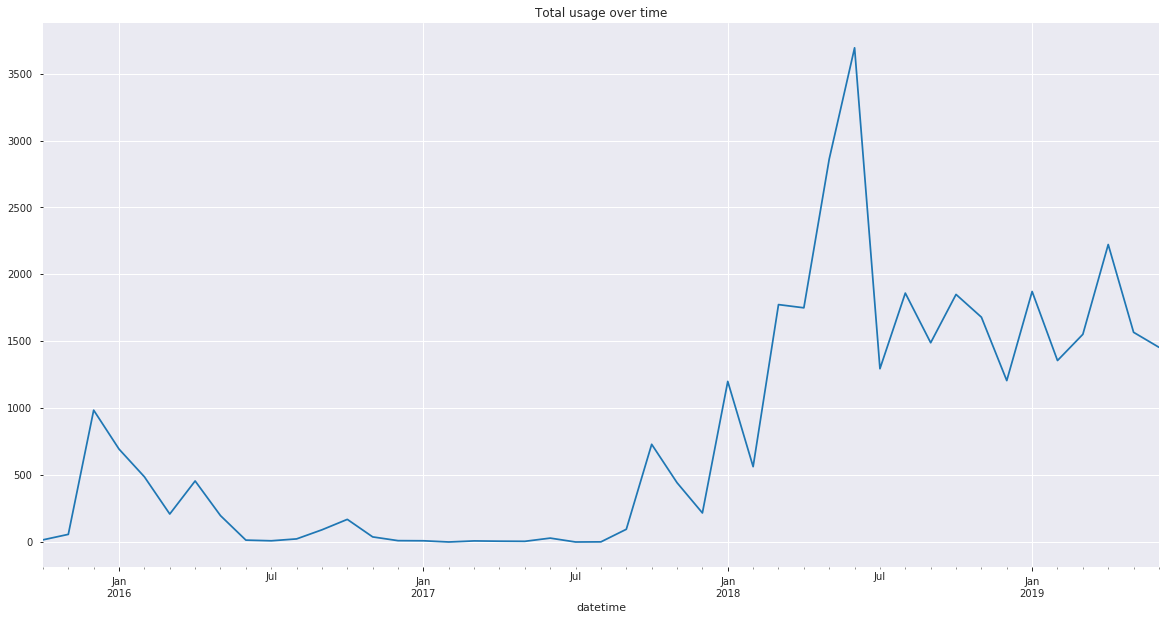

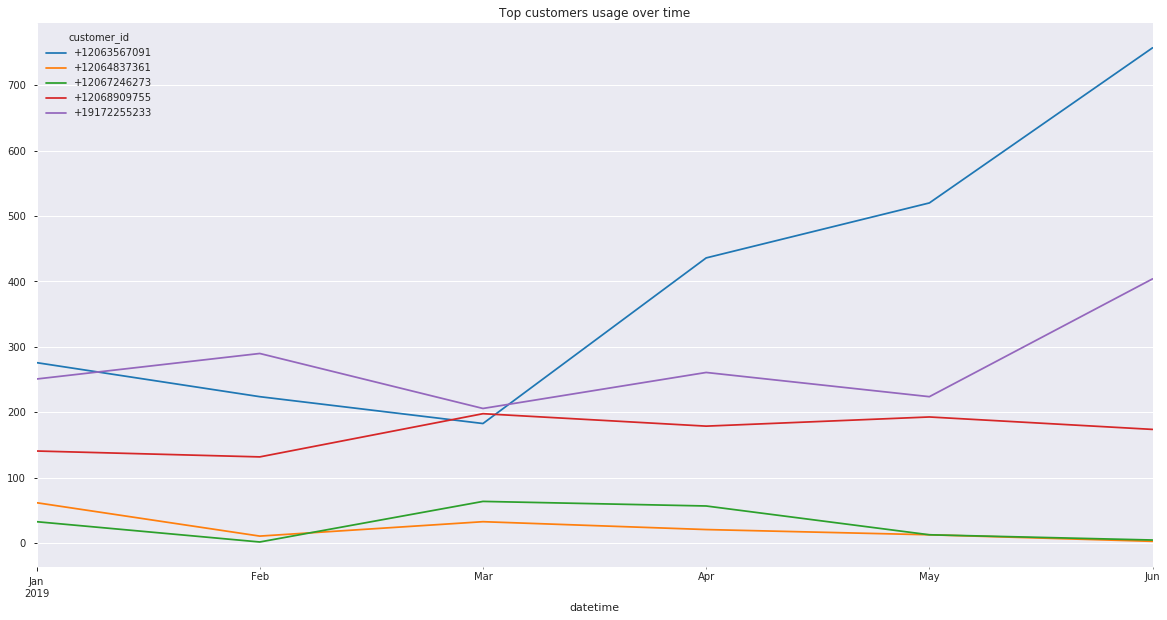

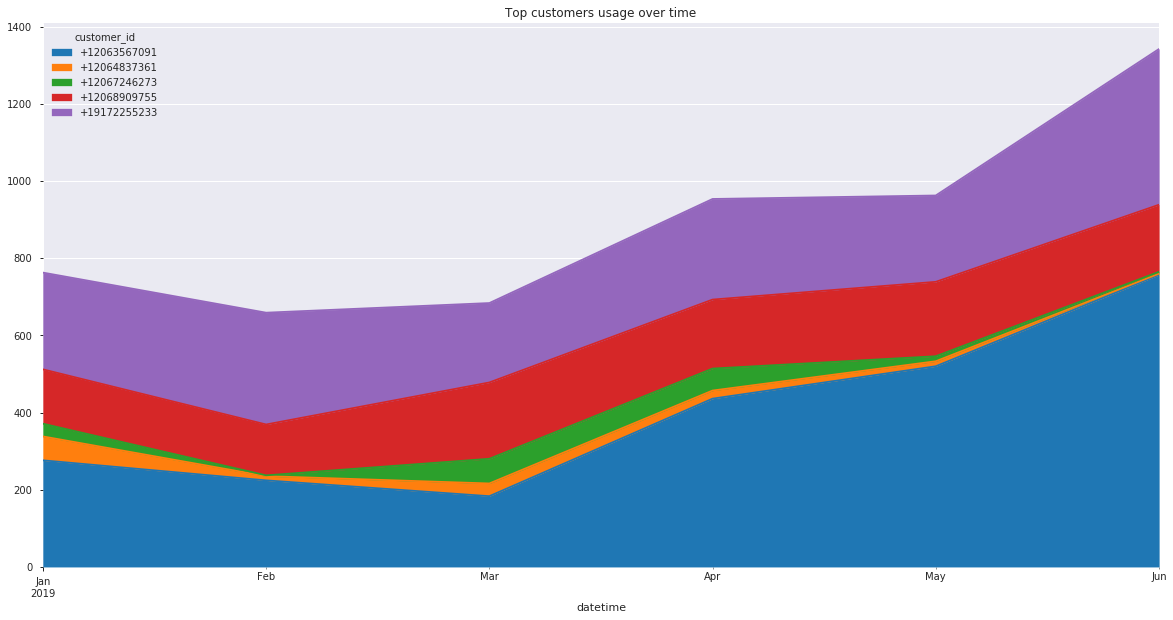

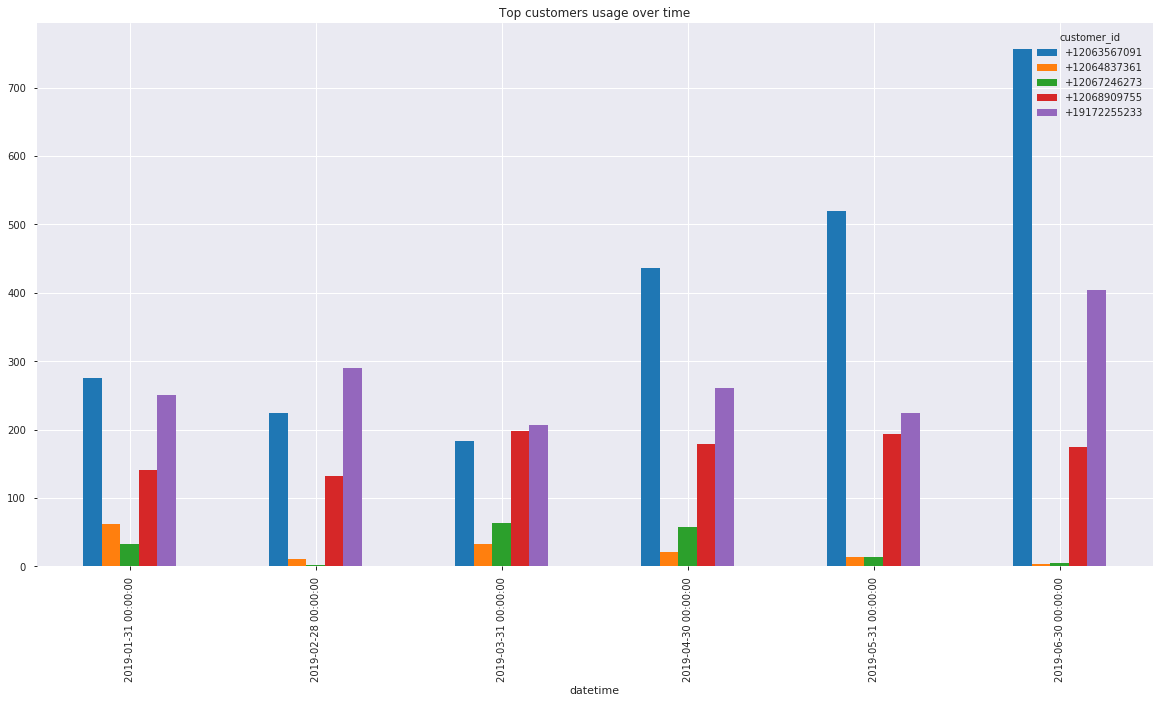

customer_by_count
+12063567091    2396
+19172255233    1636
+12068909755    1017
+12067246273     174
+12064837361     143
+19059237385     141
+12064998810      43
+14254421739      33
+12064999935      27
+12062517460      25
Name: customer_id, dtype: int64


In [17]:
df.resample("M").count()["datetime"].plot(title="Total usage over time")
plt.show()

df_tr = df["2019"]
customer_by_count = df_tr.customer_id.value_counts()
irange = range(0, 5)
df_hc = df_tr[df_tr.customer_id.isin(customer_by_count.index[irange].values)]

top_customer_by_month = df_hc.pivot_table(
    values="datetime",
    index=["customer_id"],
    columns=pd.Grouper(freq="M"),
    aggfunc="count",
    fill_value=0,
).T

for kind in "line area bar".split():
    top_customer_by_month.plot(title="Top customers usage over time", kind=kind)
    plt.show()
print(f"customer_by_count\n{customer_by_count.head(10)}")